# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
We want to train a model such that it is able to classify the incoming data point which is a reveiw text into positive review and negative review .For this task we will take in consideration of the review text and will work on it using different vectorizers like Bag of words,tfidf,and word to vector to generate features that can be feeded to our model for making predictions

<br>
####  [Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('gdrive/My Drive/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# Taking 100k datapoints

In [0]:
final = final.sample(100000)#sampling 100k datapoints 

In [16]:
final = final.sort_values('Time',ascending = True)
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...
346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,1,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h..."
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...
346078,374383,B00004CI84,A34NBH479RB0E,"""dmab6395""",0,1,1,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA..."
346054,374358,B00004CI84,A1HWMNSQF14MP8,will@socialaw.com,1,2,1,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
346029,374331,B00004CI84,A1OP3SQP78M1PP,James Gowen,0,0,1,1015718400,"A movie to ""literally die for!!!""",Beetlejuice is not a movie that you can't watc...
333922,361309,B00005IX96,A1TIVD0Y3KJSCN,"lawyerwhocooks ""lawyerwhocooks""",23,25,1,1023321600,Better than Starbucks espresso pods,Using the Briel Chamonix machine I purchased f...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I'm getting crazy.I'm looking for Beatlejuice french version video.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks
This mixer is easy to use and makes using natural peanut butter so much pleasurable.  It mixed the peanut butter thoroughly and clean up was easy.  The peanut butter was much better mixed than when we attempted to mix it ourselves with utensils.
These delicious mini-crackers are small enough to grab a satisfying handful. Yep, it's got all the organic requisites, organically-fed cows whose lips never taste hormones or antibiotics (well, maybe these are injected, I don't know), and the crackers contain non-hydrogenated, trans-fat free organic palm oil.<br /><br />The taste is mild but you can taste the cheddar, and the texture is more flakey than hard or brittle. If you grab 30 crackers (one ounce, there are 5ounces, or 150 crackers per box), you'll get 310 mg of sodium, or 13% of the Recomm

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I'm getting crazy.I'm looking for Beatlejuice french version video.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I'm getting crazy.I'm looking for Beatlejuice french version video.Is it really impossible today not to find the French VHS version of this film ?Could U please tell me something about it ? Tks
This mixer is easy to use and makes using natural peanut butter so much pleasurable.  It mixed the peanut butter thoroughly and clean up was easy.  The peanut butter was much better mixed than when we attempted to mix it ourselves with utensils.
These delicious mini-crackers are small enough to grab a satisfying handful. Yep, it's got all the organic requisites, organically-fed cows whose lips never taste hormones or antibiotics (well, maybe these are injected, I don't know), and the crackers contain non-hydrogenated, trans-fat free organic palm oil.The taste is mild but you can taste the cheddar, and the texture is more flakey than hard or brittle. If you grab 30 crackers (one ounce, there are 5ounces, or 150 crackers per box), you'll get 310 mg of sodium, or 13% of the Recommended Daily Value 

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These delicious mini-crackers are small enough to grab a satisfying handful. Yep, it is got all the organic requisites, organically-fed cows whose lips never taste hormones or antibiotics (well, maybe these are injected, I do not know), and the crackers contain non-hydrogenated, trans-fat free organic palm oil.<br /><br />The taste is mild but you can taste the cheddar, and the texture is more flakey than hard or brittle. If you grab 30 crackers (one ounce, there are 5ounces, or 150 crackers per box), you will get 310 mg of sodium, or 13% of the Recommended Daily Value (RDV) for a 2,000 calorie diet. Now that is by any means low-sodium, but you can easily eat half of that and feel you have had a snack. Per 30 crackers, there are 4.5 grams (g) oftotal fat, of which 1.5 are saturated, and none are trans fat. Total carbohydrates are 19g, including less than 1g of sugar, but also less than 1g of dietary fiber. Hey, noone said this is health food, but compare this to what you are snacking o

In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I'm getting crazy.I'm looking for Beatlejuice french version video.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These delicious mini crackers are small enough to grab a satisfying handful Yep it is got all the organic requisites organically fed cows whose lips never taste hormones or antibiotics well maybe these are injected I do not know and the crackers contain non hydrogenated trans fat free organic palm oil br br The taste is mild but you can taste the cheddar and the texture is more flakey than hard or brittle If you grab 30 crackers one ounce there are 5ounces or 150 crackers per box you will get 310 mg of sodium or 13 of the Recommended Daily Value RDV for a 2 000 calorie diet Now that is by any means low sodium but you can easily eat half of that and feel you have had a snack Per 30 crackers there are 4 5 grams g oftotal fat of which 1 5 are saturated and none are trans fat Total carbohydrates are 19g including less than 1g of sugar but also less than 1g of dietary fiber Hey noone said this is health food but compare this to what you are snacking on now and that cheese gives it 3g of pro

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:44<00:00, 2241.36it/s]


In [26]:
preprocessed_reviews[1500]

'delicious mini crackers small enough grab satisfying handful yep got organic requisites organically fed cows whose lips never taste hormones antibiotics well maybe injected not know crackers contain non hydrogenated trans fat free organic palm oil taste mild taste cheddar texture flakey hard brittle grab crackers one ounce crackers per box get mg sodium recommended daily value rdv calorie diet means low sodium easily eat half feel snack per crackers grams g oftotal fat saturated none trans fat total carbohydrates including less sugar also less dietary fiber hey noone said health food compare snacking cheese gives protein full ingredients nutritional information may found latejuly com products good stuff includes organic wheat flour organic whey sea salt organic evaporated cane juice nothing artificial no corn syrup preservatives hydrogenated oils kosher lacto vegetarian gotta make sure no meat crackers not enough late july independently owned family operated mainly though light taste 

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size=0.3,random_state = 42)
print('After Splitting size of:\n')
print('Train Datset is:',np.array(X_train).shape)
print('Test Datset is:',np.array(X_test).shape)

After Splitting size of:

Train Datset is: (70000,)
Test Datset is: (30000,)


# [4] Featurization

### READING THE FILES

### BAG OF WORDS

In [28]:
bow_vect = CountVectorizer()#initiating the vectorizer
bow_vect.fit(X_train)#fittin the data into vectorizer makes it learn from the corpus

train_bow = bow_vect.transform(X_train)
test_bow = bow_vect.transform(X_test)

print('TRAINING SET FOR BAG OF WORDS',train_bow.shape)
print('TEST SET FOR BAG OF WORDS',test_bow.shape)

TRAINING SET FOR BAG OF WORDS (70000, 50640)
TEST SET FOR BAG OF WORDS (30000, 50640)


In [0]:
import pickle
pickle.dump(train_bow,open('train_bow.p','wb'))
pickle.dump(test_bow,open('test_bow.p','wb'))

### TFIDF

In [0]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
tfidf_vect.fit(X_train)

train_tfidf = tfidf_vect.transform(X_train)
test_tfidf = tfidf_vect.transform(X_test)



In [0]:
pickle.dump(train_tfidf,open('train_tfidf.p','wb'))
pickle.dump(test_tfidf,open('test_tfidf.p','wb'))

## Word 2 vector

In [0]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
#preparing the training data for  word to vector vectorization    
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
#preparing the test data for word to vector fatorization

In [33]:
w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)# min_count = 5 considers only words that occured atleast 5 times

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  16090


### Average Word 2 Vector

In [34]:
#Average word2vec
#computing average word to vector for training data 

train_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_set.append(sent_vec)

print(len(train_set))#number of datapoints in training set

100%|██████████| 70000/70000 [02:20<00:00, 499.37it/s]

70000


In [35]:
#computing average word to vector for test data 

test_set = [] # the avg-w2v for each sentence/review is stored in this list
for sent in s_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_set.append(sent_vec)

print(len(test_set))#number of datapoints in test set

30000


In [0]:
pickle.dump(train_set,open('train_avgw2v.p','wb'))
pickle.dump(test_set,open('test_avgw2v.p','wb'))

### TFIDF WORD 2 VECTOR

In [0]:
#tfidf word 2 vec

vect = TfidfVectorizer()#initializing the tfidf vectorizer 

tf_idf = vect.fit_transform(X_train)#fitting the training data
dictionary = dict(zip(vect.get_feature_names(), list(vect.idf_)))#zipping both of the feature names and vectorizer idf scores

In [38]:
import itertools
dict(itertools.islice(dictionary.items(),20))
#printing first 20 elements of the dictionary

{'aa': 9.853679713649695,
 'aaa': 10.076823264963906,
 'aaaa': 11.057652517975633,
 'aaaaa': 10.769970445523851,
 'aaaaaaaaaaaaa': 11.463117626083797,
 'aaaaaaaaaaaaaa': 11.463117626083797,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 11.463117626083797,
 'aaaaaaahhhhhh': 11.463117626083797,
 'aaaaaah': 11.057652517975633,
 'aaaaaahhh': 11.463117626083797,
 'aaaaaahhhh': 11.463117626083797,
 'aaaaaawwwwwwwwww': 11.463117626083797,
 'aaaah': 11.463117626083797,
 'aaaahhhhhhhhhhh': 11.463117626083797,
 'aaaannnnddd': 11.463117626083797,
 'aaah': 11.057652517975633,
 'aadults': 11.463117626083797,
 'aafco': 10.210354657588429,
 'aafes': 10.769970445523851,
 'aah': 11.463117626083797}

In [39]:
tfidf_feat = vect.get_feature_names() # tfidf words/col-names
print(tfidf_feat[:20])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaaawwwwwwwwww', 'aaaah', 'aaaahhhhhhhhhhh', 'aaaannnnddd', 'aaah', 'aadults', 'aafco', 'aafes', 'aah']


In [40]:
train_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in training set is stored in this list
row=0;
for sent in tqdm(s_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_set_tfidfw2v.append(sent_vec)
    row += 1    
print(len(train_set_tfidfw2v))

100%|██████████| 70000/70000 [30:52<00:00, 37.79it/s]

70000


In [41]:
test_set_tfidfw2v = []; # the tfidf-w2v for each sentence/review in test set is stored in this list
row=0;
for sent in tqdm(s_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_set_tfidfw2v.append(sent_vec)
    row += 1
    
print(len(test_set_tfidfw2v))


100%|██████████| 30000/30000 [13:20<00:00, 37.47it/s]

30000


In [0]:
import pickle
pickle.dump(train_set_tfidfw2v,open('train_tfidfw2v.p','wb'))
pickle.dump(test_set_tfidfw2v,open('test_tfidfw2v.p','wb'))

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>


<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve





In [0]:
#opening adn reading all the saved files\

#BAG OF VECTORS
train_bow = pickle.load(open('train_bow.p','rb'))
test_bow = pickle.load(open('test_bow.p','rb'))






In [0]:
#function for tuning the hyperparameters
alpha = [10**i for i in range(-4,5,1)]
tscv = TimeSeriesSplit(n_splits =  5)# for times series cross validation
params = {'alpha':alpha}

def svm(regularization,train_set,train_y):
    clf = SGDClassifier(penalty = regularization,loss = 'hinge',random_state = 42)
    #we will be checking for both l1 and l2 regularizations
    gsm = GridSearchCV(clf,param_grid = params,verbose = 1,cv = tscv,scoring = 'roc_auc',return_train_score = True)
    #cv = tscv does cross validation according to time series split
    gsm.fit(train_set,train_y)
    return gsm
#*************************************************************************************************************************

def error(regularization,train_set,train_y):
    print('Corresponding hypereparameter will give best auc on CV data')
    gsm = svm(regularization,train_set,train_y)
    best_alpha = gsm.best_params_
    t_auc = gsm.cv_results_['mean_train_score']
    cv_auc = gsm.cv_results_['mean_test_score']
    print('best hyperparameter is',best_alpha)
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,6))
    plt.plot(alpha,t_auc,'g',label = 'training AUC')#t_auc refers to the auc on training data
    plt.plot(alpha,cv_auc,'r',label='validation AUC')# c_auc refers to the auc on cross validation data
#plotting the graph between AUC and hyperparameter for tuning 

    plt.xscale('log')#taking log scale for x axis for better analysing the results
    plt.xlabel('hyperparameter Alpha',fontsize=18)
    plt.ylabel('Area under curve',fontsize=18)
    #plt.xticks([])
    #plt.yticks([])
    plt.legend(loc = 'best')
    plt.title('AUC vs hyperparameter ',fontsize=18)
    return best_alpha
    

#****************************************************************************************************************************

def best_classifier(best_alpha,regularization,train_set,train_y,test_set,test_y):
    clf_optimal = SGDClassifier(alpha = best_alpha,penalty = regularization,loss = 'hinge',random_state = 42)
    clf_optimal.fit(train_set,train_y)
    clb = CalibratedClassifierCV(clf_optimal,cv = 5,method = 'sigmoid')
    clb.fit(train_set,train_y)
    train_proba = clb.predict_proba(train_set)[:,1]
    test_proba = clb.predict_proba(test_set)[:,1]
    
    pred_tr = clb.predict(train_set)
    pred_test = clb.predict(test_set)
    
    train_auc = roc_auc_score(train_y,train_proba)
    test_auc = roc_auc_score(test_y,test_proba)
    
    print('AUC on training data is',train_auc)
    print('AUC on test data is',test_auc)
    return train_auc,test_auc,train_proba,test_proba,pred_tr,pred_test

#*****************************************************************************************************************************

#computing function for reliability curve
#referred to :https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
def reliability_curve(best_alpha,regularization,trainX, testX, train_y,test_y):
    def uncalibrated(best_alpha,regularization,trainX, testX, train_y):
     # fit a model
        model = SGDClassifier(alpha = best_alpha,penalty = regularization,loss = 'hinge',random_state = 42)
        model.fit(trainX, train_y)
     # predict probabilities
        return model.decision_function(testX)
 
     #predict calibrated probabilities
    def calibrated(best_alpha,regularization,trainX, testX, train_y):
        # define model
        model = SGDClassifier(alpha = best_alpha,penalty = regularization,loss = 'hinge',random_state = 42)
        # define and fit calibration model
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        calibrated.fit(trainX, train_y)
        # predict probabilities
        return calibrated.predict_proba(testX)[:, 1]
    # generate 2 class dataset

    # uncalibrated predictions
    yhat_uncalibrated = uncalibrated(best_alpha,regularization,trainX, testX, train_y)
    # calibrated predictions
    yhat_calibrated = calibrated(best_alpha,regularization,trainX, testX, train_y)
    # reliability diagrams
    fop_uncalibrated, mpv_uncalibrated = calibration_curve(test_y, yhat_uncalibrated, n_bins=10, normalize=True)
    fop_calibrated, mpv_calibrated = calibration_curve(test_y, yhat_calibrated, n_bins=10)
    # plot perfectly calibrated
    plt.figure(figsize = (15,6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    # plot model reliabilities
    plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'Uncalibrated')
    plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'Calibrated')
    plt.xlabel('Expected Probabilities',fontsize  =18)
    plt.ylabel('Predicted Probabilities',fontsize=18)
    plt.legend(loc = 'best')
    plt.title('Calibrated vs Uncalibrated',fontsize  =18)
    plt.show()
    
#***************************************************************************************************************************



In [0]:

def plot_confusion_matrix(test_y, pred_y):
    print('Confusion Matrix')
    C = confusion_matrix(test_y, pred_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)#for recall matrix
    
    B =(C/C.sum(axis=0))#for precision matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    

#***************************************************************************************************************


def plot_roc(train_y,train_proba,test_y,test_proba,auc_train,auc_test):
    print('plotting ROC on Test data')
    fpr_tr, tpr_tr, _ = roc_curve(train_y,train_proba)
    fpr_test, tpr_test, _ = roc_curve(test_y,test_proba)
    #calculating the fpr,tpr and thresholds for each training and test dataset
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,8))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")#this plots the roc curve for AUC = 0.5
    plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
    plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
    plt.xlabel('False positive rate(1-specificity)',fontsize=18)
    plt.ylabel('True positive rate(sensitivity)',fontsize=18)
    plt.title('Reciever operating characteristics curve',fontsize=18)
    plt.legend(loc='best')
    plt.show()
    
#****************************************************************************************************************

def imp_features(best_alpha,regularization,train_set,train_y,vect):
    clf = SGDClassifier(alpha = best_alpha,penalty = regularization,loss = 'hinge',random_state = 42)
    clf.fit(train_set,train_y)
    w = clf.coef_[0]#finding the coefficients of all features
    #print(w)
    
    features = vect.get_feature_names()#getting name of the features after fitting and transforming by countvectorizer
    negative_indices = np.argsort(w)
    positive_indices = np.argsort(w)[::-1]
    pos_dict = {}
    neg_dict = {}
    


    print('TOP 20 important features for positive class and their coefficients in this featurization are:\n')
    for i in (positive_indices[0:20]):
        pos_dict[features[i]] = w[i]
        #print("%s\t --> \t%f"%(features[i],w[i]))
    pos_df = pd.DataFrame.from_dict(pos_dict,orient = 'index',columns=['Coefficients'])
    print(pos_df)
    print("************************************************")


    print('TOP 20 important features for negative class and their coefficients in this featurization are:\n')
    for i in (negative_indices[0:20]):
        neg_dict[features[i]] = w[i]
    neg_df = pd.DataFrame.from_dict(neg_dict,orient = 'index',columns=['Coefficients'])
    print(neg_df)
        
  

## Using L2 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.5s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.8s finished


best hyperparameter is {'alpha': 0.001}
***************************************************************

AUC on training data is 0.9635540335920942
AUC on test data is 0.9402083193654796
*******************************************************************
The Calibration Curve


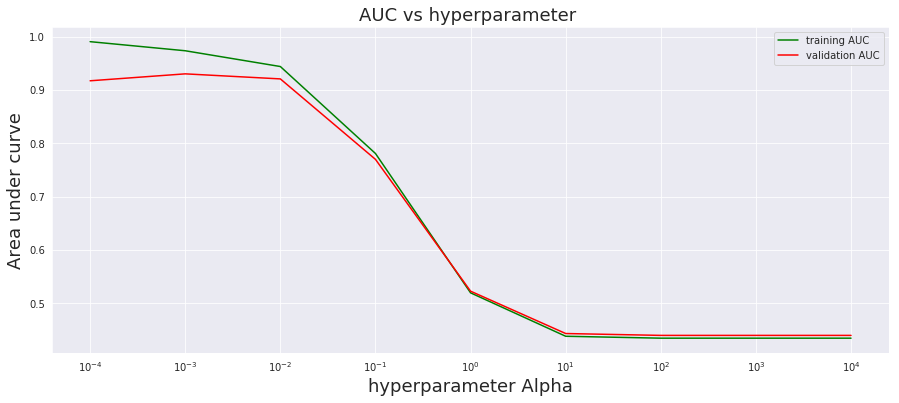

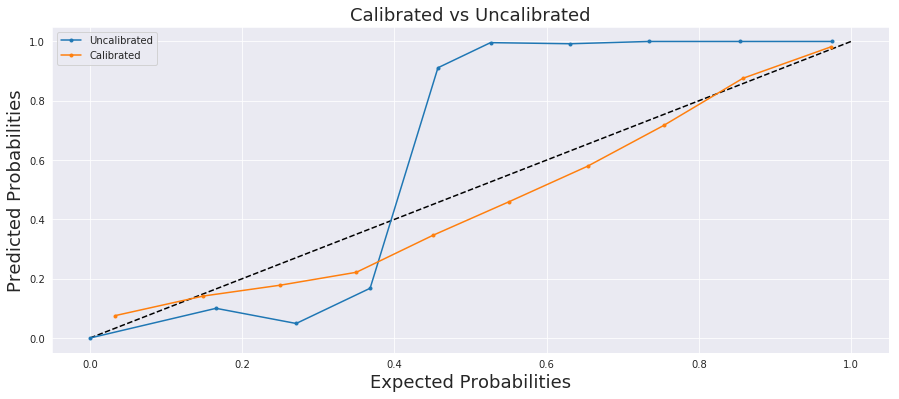

*********************************************************************

for Training data:

Confusion Matrix


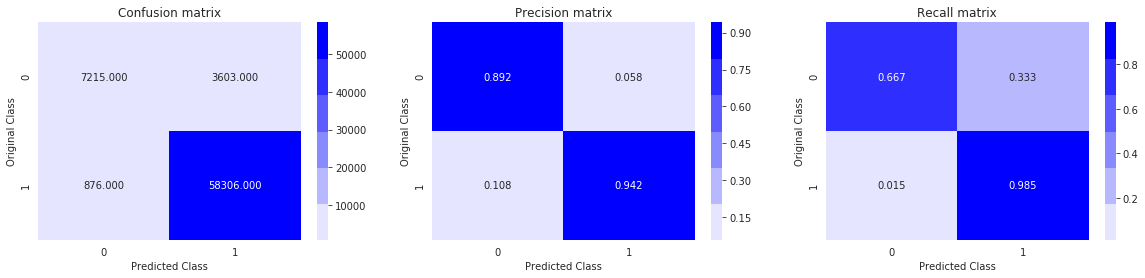

for Test data
Confusion Matrix


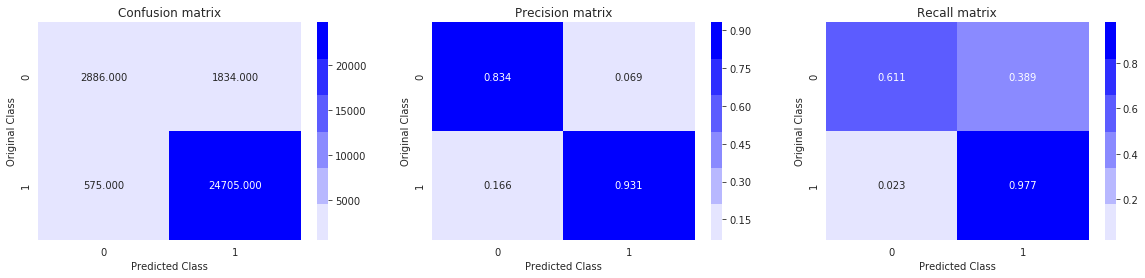

********************************************************

plotting ROC on Test data


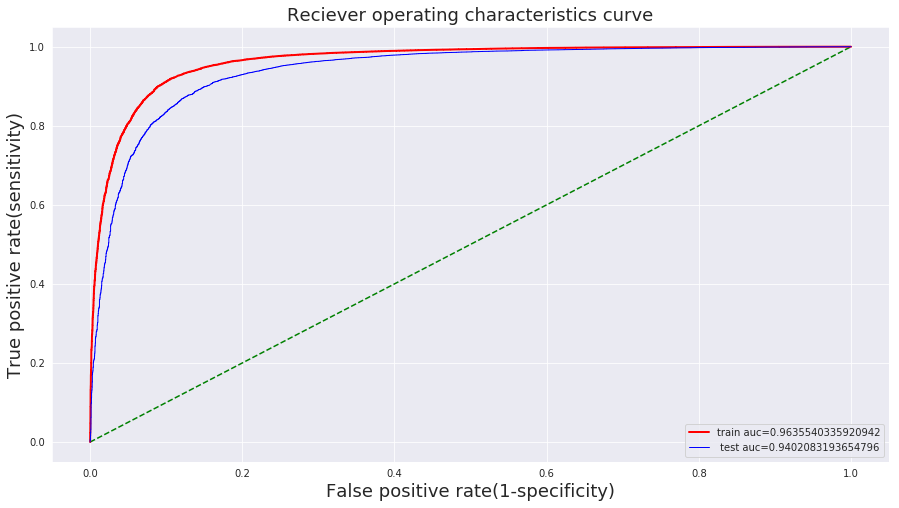

In [50]:
"""classifier for tuning"""
gsm = svm('l2',train_bow,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l2_bow = error('l2',train_bow,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l2_bow,test_auc_l2_bow,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l2_bow, \
                                            'l2',train_bow,Y_train,test_bow,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l2_bow,'l2',train_bow,test_bow,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l2_bow,test_auc_l2_bow)




In [0]:
"""TOP Features for both classes"""
imp_features(best_alpha_l2_bow,'l2',train_bow,Y_train,bow_vect)

TOP 20 important features for positive class and their coefficients in Bag of Words featurization are:

            Coefficients
delicious       0.628254
perfect         0.591130
excellent       0.565429
great           0.508315
highly          0.508315
awesome         0.505459
smooth          0.474046
amazing         0.468335
yummy           0.465479
best            0.456912
wonderful       0.431211
happy           0.422644
loves           0.422644
nice            0.408365
thank           0.399798
tasty           0.379808
definitely      0.376952
complaint       0.376952
fantastic       0.376952
pleased         0.374097
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization are:

                Coefficients
worst              -0.899546
awful              -0.842432
disappointing      -0.796740
disappointed       -0.699647
disappointment     -0.696791
threw              -0.696791
terrible       

# Using L1 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   29.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   28.5s finished


best hyperparameter is {'alpha': 0.0001}
***************************************************************

AUC on training data is 0.956162146262999
AUC on test data is 0.9303229130350246
*******************************************************************
The Calibration Curve


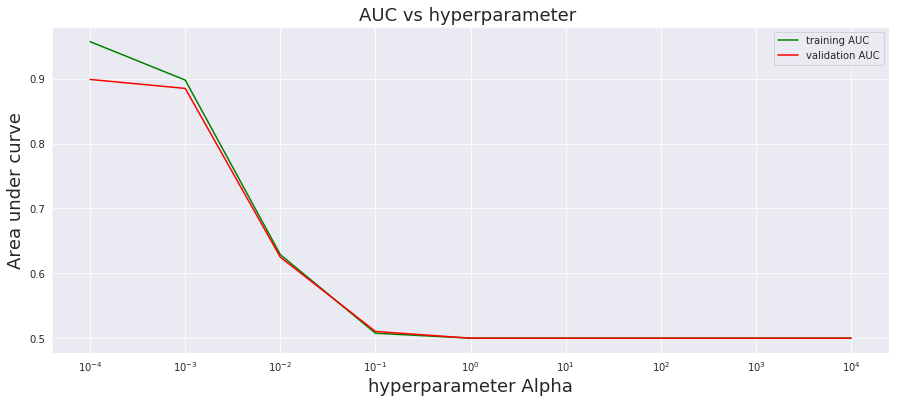

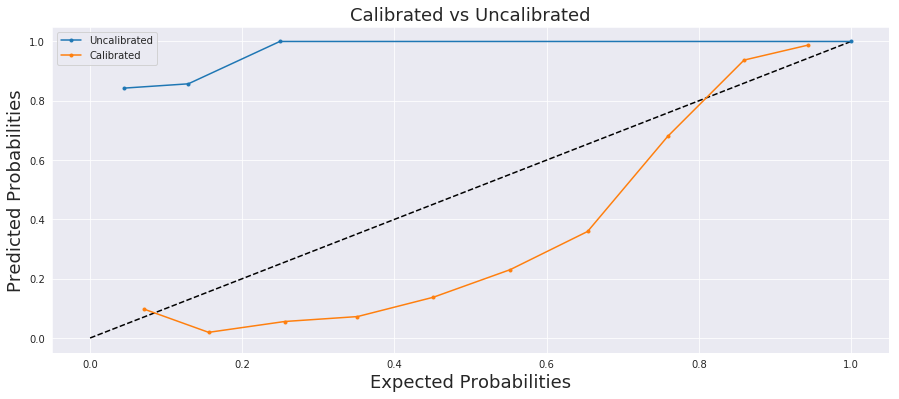

*********************************************************************

for Training data:

Confusion Matrix


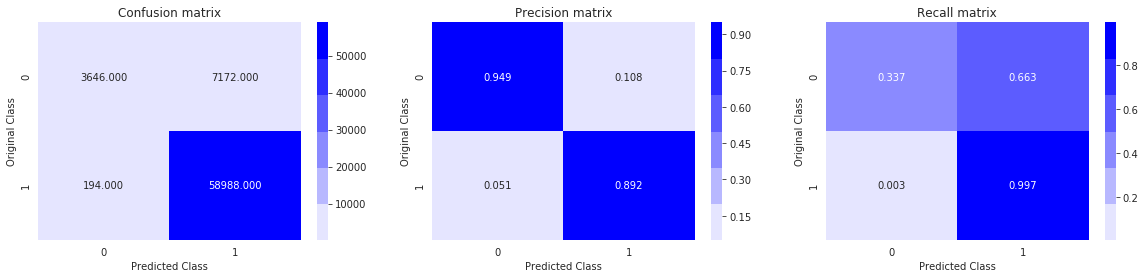

for Test data
Confusion Matrix


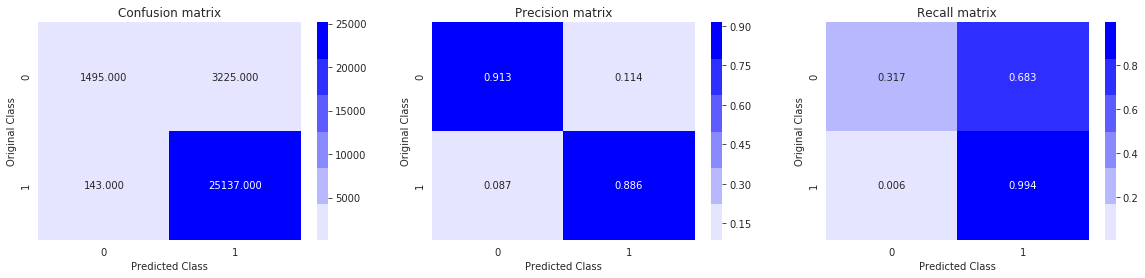

********************************************************

plotting ROC on Test data


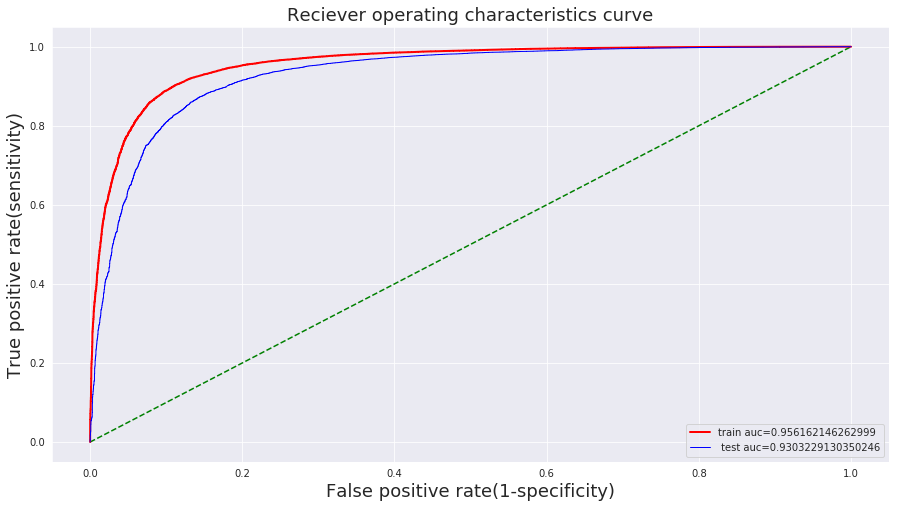

In [51]:
"""classifier for tuning"""
gsm = svm('l1',train_bow,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l1_bow = error('l1',train_bow,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l1_bow,test_auc_l1_bow,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l1_bow, \
                                            'l1',train_bow,Y_train,test_bow,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l1_bow,'l1',train_bow,test_bow,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l1_bow,test_auc_l1_bow)




In [0]:
"""TOP Features for both classes"""
imp_features(best_alpha_l1_bow,'l1',train_bow,Y_train,bow_vect)

TOP 20 important features for positive class and their coefficients in Bag of Words featurization are:

              Coefficients
knife           104.474975
corner           76.963398
edge             76.236796
gently           74.148043
point            53.998964
proceed          44.844656
tofu             42.977610
slowly           41.747194
withdraw         38.607035
izze             38.357197
slit             38.241826
gentle           35.820080
tip              33.461279
slits            29.697758
insulin          29.464263
membrane         28.668077
procedure        28.603500
sulfate          26.594956
vegetable        23.110526
constipation     22.643934
************************************************
TOP 20 important features for negative class and their coefficients in Bag of Words featurization are:

                Coefficients
iams              -43.559593
disappointing     -32.887452
pureed            -32.127471
milka             -29.474204
disappointment    -28.367887
wo

# [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
#reading tfidf files
train_tfidf = pickle.load(open('train_tfidf.p','rb'))
test_tfidf = pickle.load(open('test_tfidf.p','rb'))


## Using L2 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.5s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.3s finished


best hyperparameter is {'alpha': 0.0001}
***************************************************************

AUC on training data is 0.9736325736030264
AUC on test data is 0.9557599378486376
*******************************************************************
The Calibration Curve


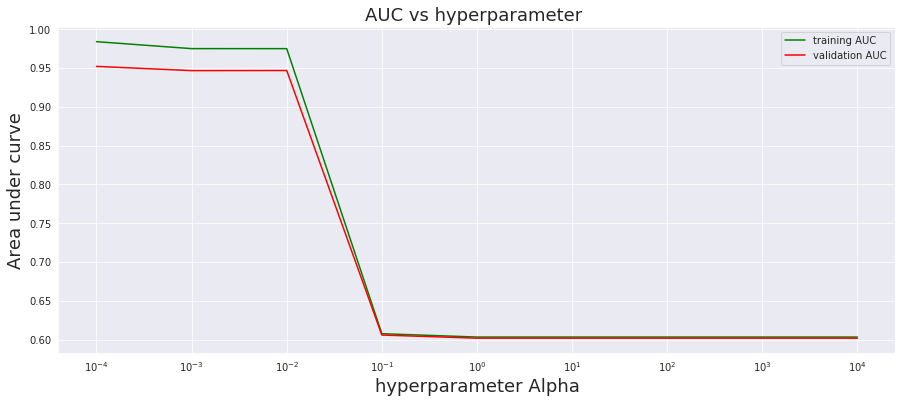

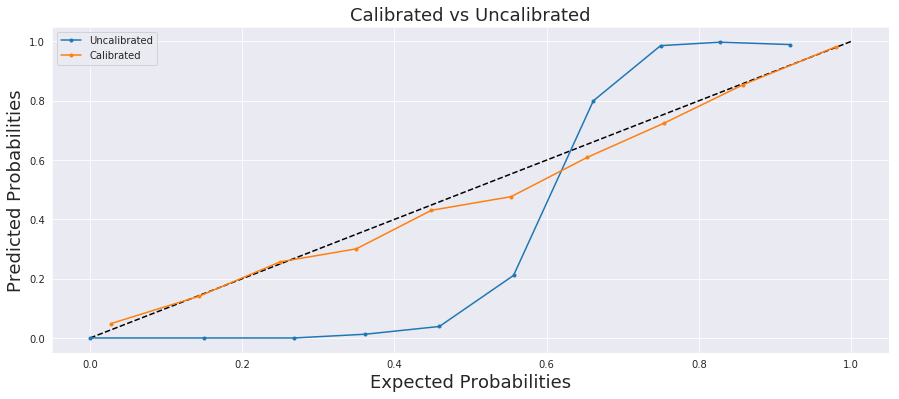

*********************************************************************

for Training data:

Confusion Matrix


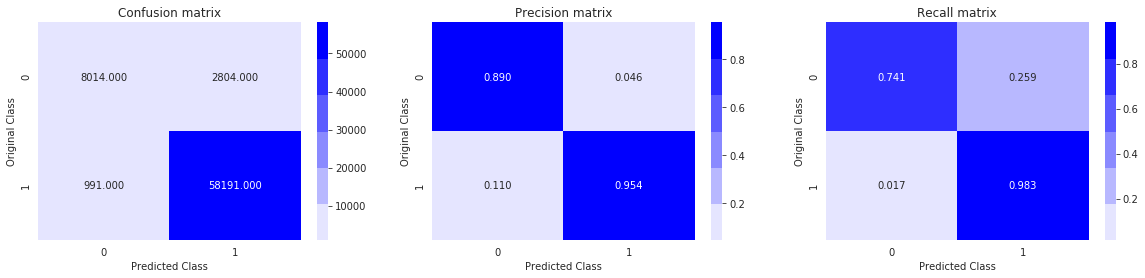

for Test data
Confusion Matrix


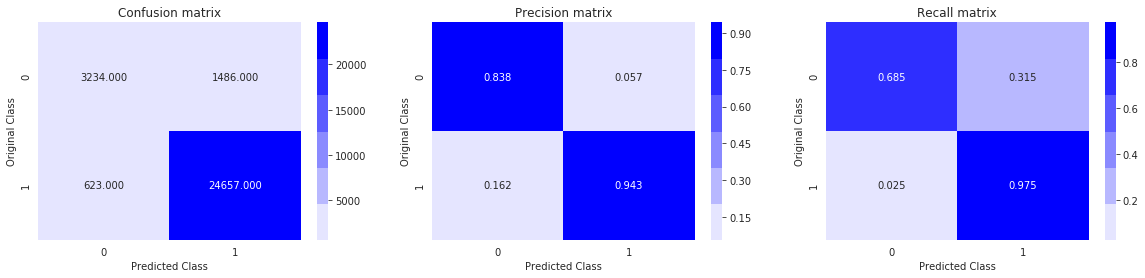

********************************************************

plotting ROC on Test data


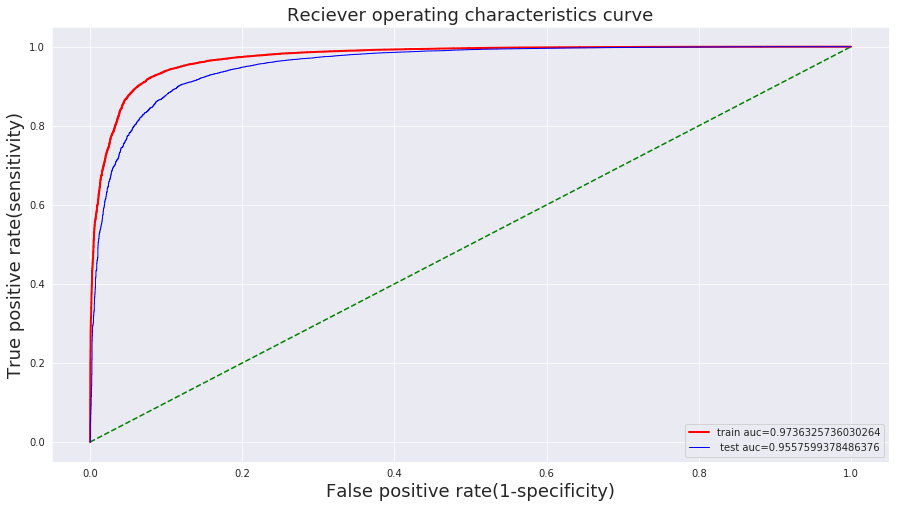

In [53]:
"""classifier for tuning"""
gsm = svm('l2',train_tfidf,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l2_tfidf = error('l2',train_tfidf,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l2_tfidf,test_auc_l2_tfidf,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l2_tfidf, \
                                            'l2',train_tfidf,Y_train,test_tfidf,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l2_tfidf,'l2',train_tfidf,test_tfidf,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l2_tfidf,test_auc_l2_tfidf)



In [0]:
"""TOP Features for both classes"""
imp_features(best_alpha_l2_tfidf,'l2',train_tfidf,Y_train,tfidf_vect)

TOP 20 important features for positive class and their coefficients in this featurization are:

                  Coefficients
great                 3.524112
best                  2.738388
delicious             2.585764
not disappointed      2.428233
good                  2.368122
love                  2.120625
perfect               2.036168
excellent             1.951569
nice                  1.904471
loves                 1.776171
happy                 1.586472
not bad               1.552323
wonderful             1.540727
amazing               1.493950
awesome               1.490634
tasty                 1.484353
yummy                 1.462984
favorite              1.450721
definitely            1.333967
smooth                1.324058
************************************************
TOP 20 important features for negative class and their coefficients in this featurization are:

               Coefficients
disappointed      -3.998880
worst             -3.453786
awful             -3.165

## Using L1 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   16.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   17.0s finished


best hyperparameter is {'alpha': 0.0001}
***************************************************************

AUC on training data is 0.9369532257610144
AUC on test data is 0.9330814202960738
*******************************************************************
The Calibration Curve


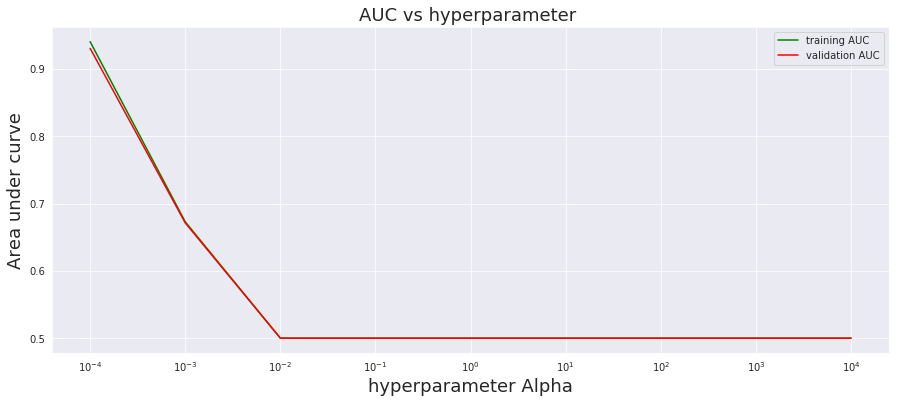

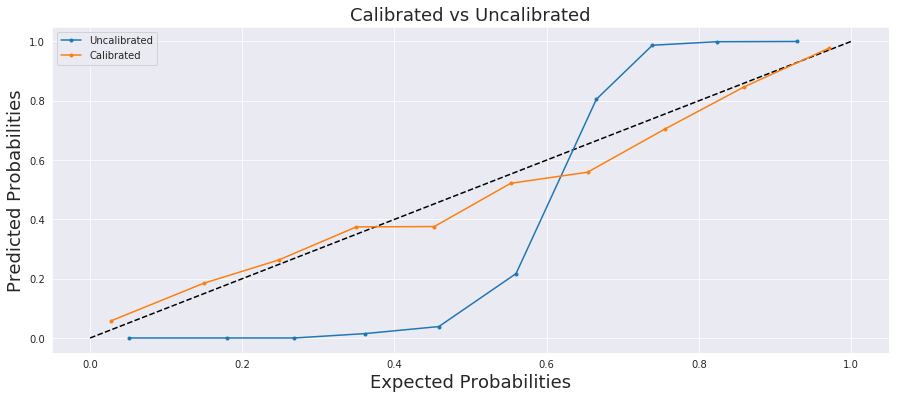

*********************************************************************

for Training data:

Confusion Matrix


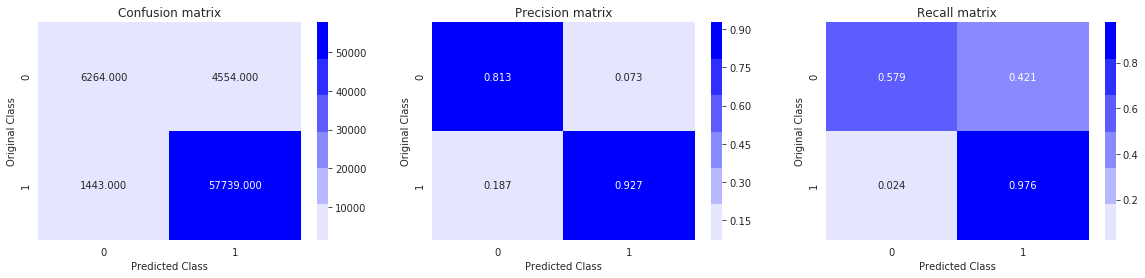

for Test data
Confusion Matrix


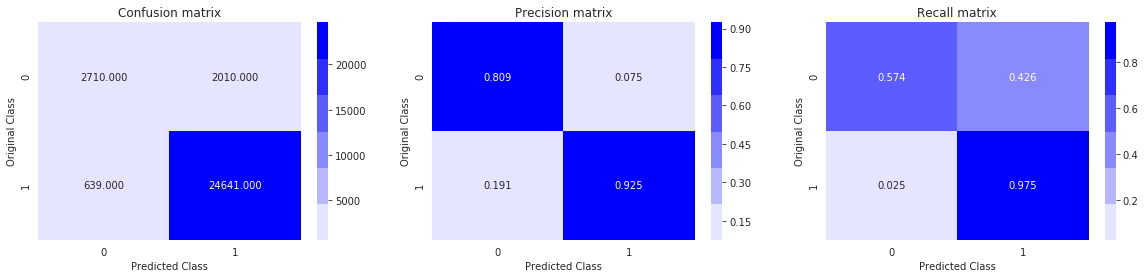

********************************************************

plotting ROC on Test data


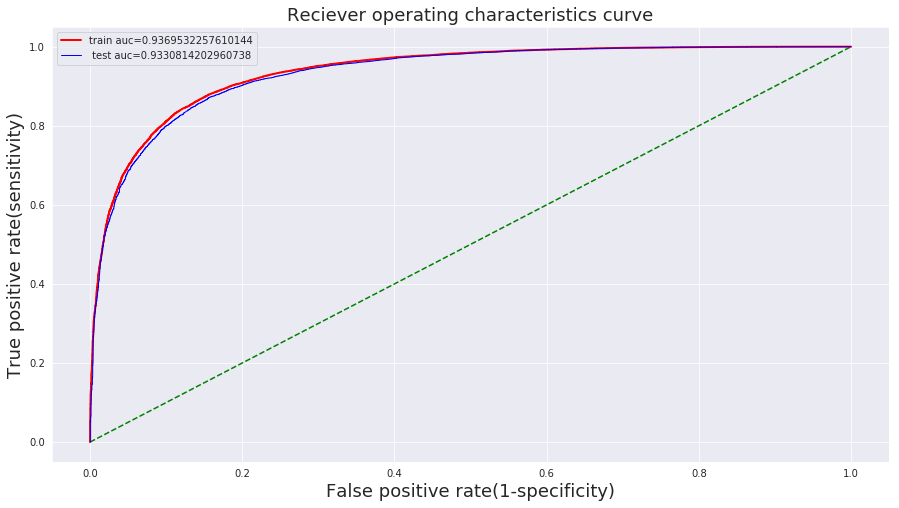

In [54]:
"""classifier for tuning"""
gsm = svm('l1',train_tfidf,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l1_tfidf = error('l1',train_tfidf,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l1_tfidf,test_auc_l1_tfidf,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l1_tfidf, \
                                            'l1',train_tfidf,Y_train,test_tfidf,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l1_tfidf,'l1',train_tfidf,test_tfidf,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l1_tfidf,test_auc_l1_tfidf)



In [0]:
"""TOP Features for both classes"""
imp_features(best_alpha_l1_tfidf,'l2',train_tfidf,Y_train,tfidf_vect)

TOP 20 important features for positive class and their coefficients in this featurization are:

                  Coefficients
great                 3.524112
best                  2.738388
delicious             2.585764
not disappointed      2.428233
good                  2.368122
love                  2.120625
perfect               2.036168
excellent             1.951569
nice                  1.904471
loves                 1.776171
happy                 1.586472
not bad               1.552323
wonderful             1.540727
amazing               1.493950
awesome               1.490634
tasty                 1.484353
yummy                 1.462984
favorite              1.450721
definitely            1.333967
smooth                1.324058
************************************************
TOP 20 important features for negative class and their coefficients in this featurization are:

               Coefficients
disappointed      -3.998880
worst             -3.453786
awful             -3.165

# [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
#Average WORD 2 VECTOR
train_avgw2v = pickle.load(open('train_avgw2v.p','rb'))
test_avgw2v = pickle.load(open('test_avgw2v.p','rb'))

## Using L2 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.3s finished


best hyperparameter is {'alpha': 0.001}
***************************************************************

AUC on training data is 0.9074093991368202
AUC on test data is 0.9058933923111994
*******************************************************************
The Calibration Curve


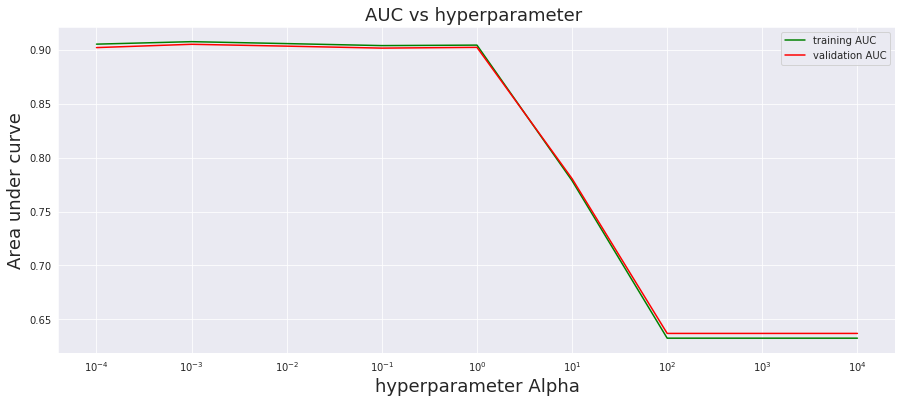

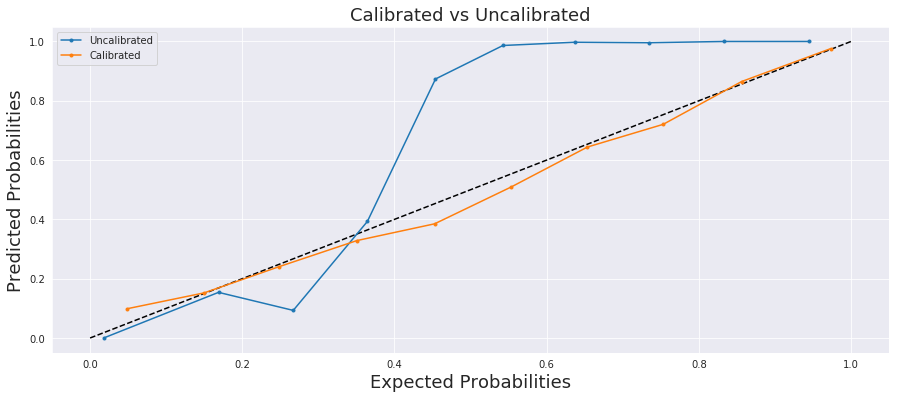

*********************************************************************

for Training data:

Confusion Matrix


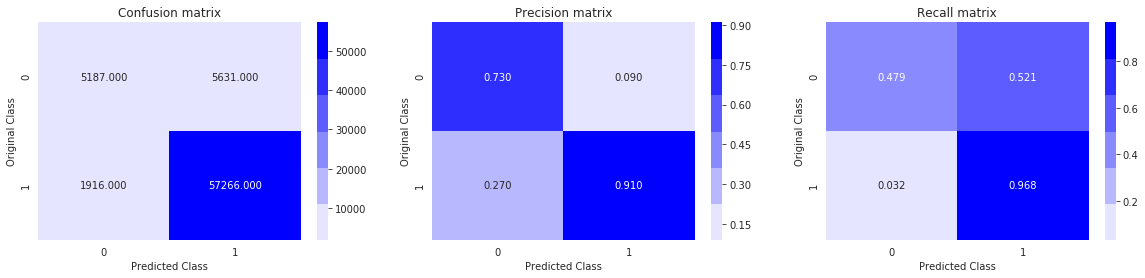

for Test data
Confusion Matrix


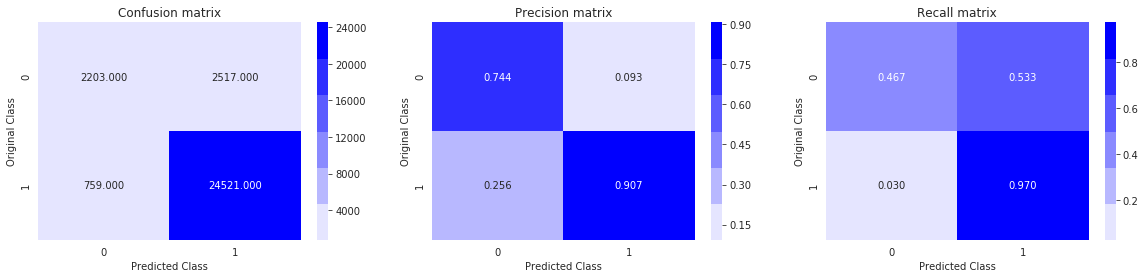

********************************************************

plotting ROC on Test data


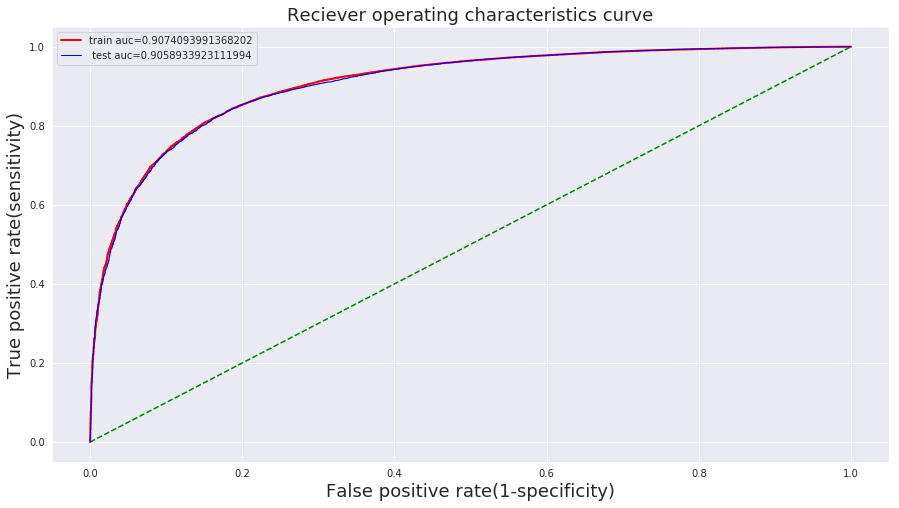

In [57]:
"""classifier for tuning"""
gsm = svm('l2',train_avgw2v,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l2_avgw2v = error('l2',train_avgw2v,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l2_avgw2v,test_auc_l2_avgw2v,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l2_avgw2v, \
                                            'l2',train_avgw2v,Y_train,test_avgw2v,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l2_avgw2v,'l2',train_avgw2v,test_avgw2v,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l2_avgw2v,test_auc_l2_avgw2v)


## Using L1 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   14.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   14.3s finished


best hyperparameter is {'alpha': 0.001}
***************************************************************

AUC on training data is 0.9069544023365721
AUC on test data is 0.9056091185502038
*******************************************************************
The Calibration Curve


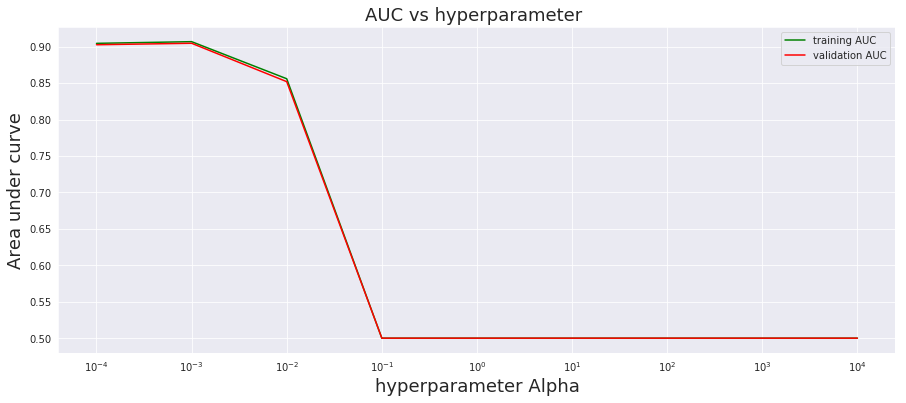

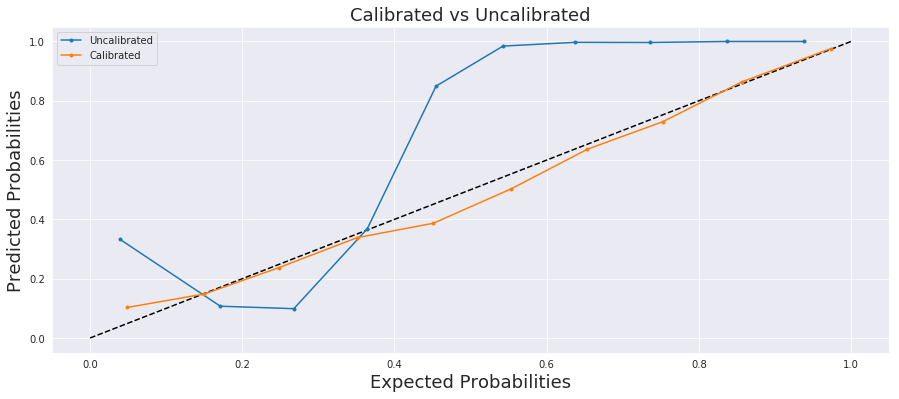

*********************************************************************

for Training data:

Confusion Matrix


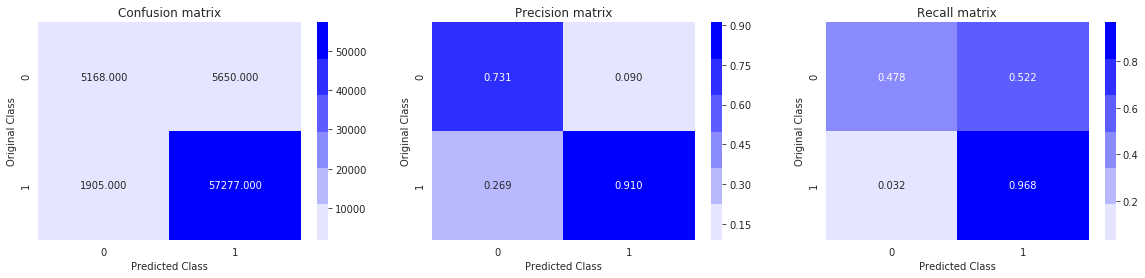

for Test data
Confusion Matrix


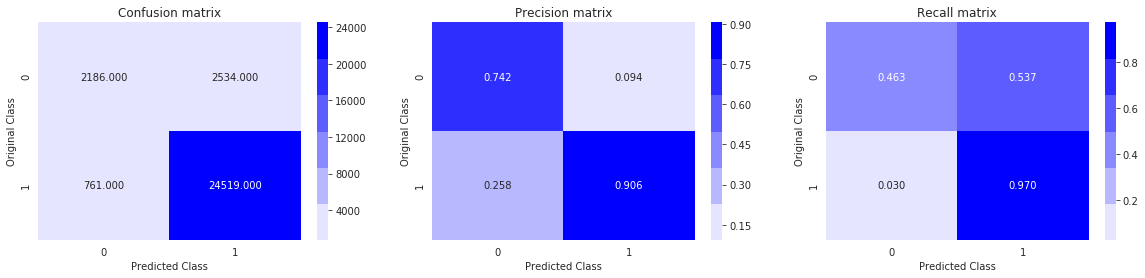

********************************************************

plotting ROC on Test data


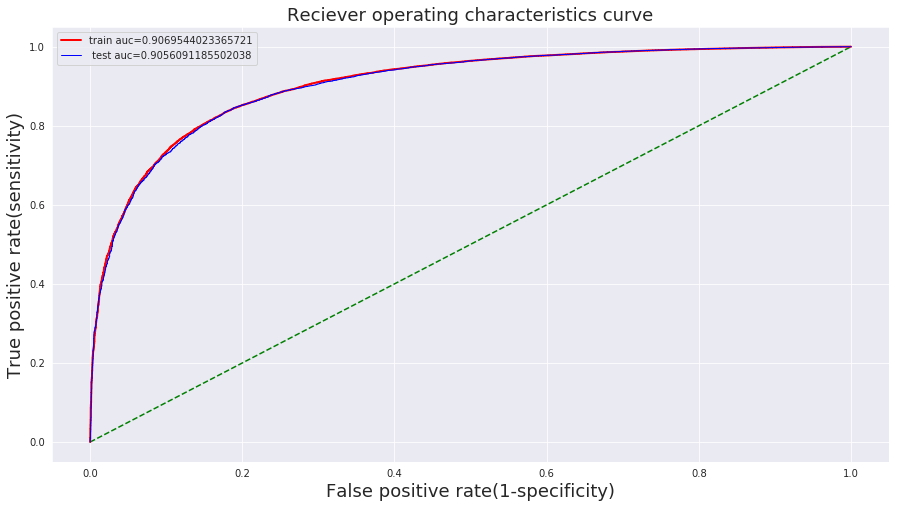

In [58]:
"""classifier for tuning"""
gsm = svm('l1',train_avgw2v,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l1_avgw2v = error('l1',train_avgw2v,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l1_avgw2v,test_auc_l1_avgw2v,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l1_avgw2v, \
                                            'l1',train_avgw2v,Y_train,test_avgw2v,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l1_avgw2v,'l1',train_avgw2v,test_avgw2v,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l1_avgw2v,test_auc_l1_avgw2v)


# [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
#TFIDF WORD 2 VECTOR
train_tfidfw2v = pickle.load(open('train_tfidfw2v.p','rb'))
test_tfidfw2v = pickle.load(open('test_tfidfw2v.p','rb'))

print(len(train_tfidfw2v))
print(len(test_tfidfw2v))

70000
30000


## Using L2 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   11.3s finished


best hyperparameter is {'alpha': 0.001}
***************************************************************

AUC on training data is 0.881121875946514
AUC on test data is 0.8774580042506973
*******************************************************************
The Calibration Curve


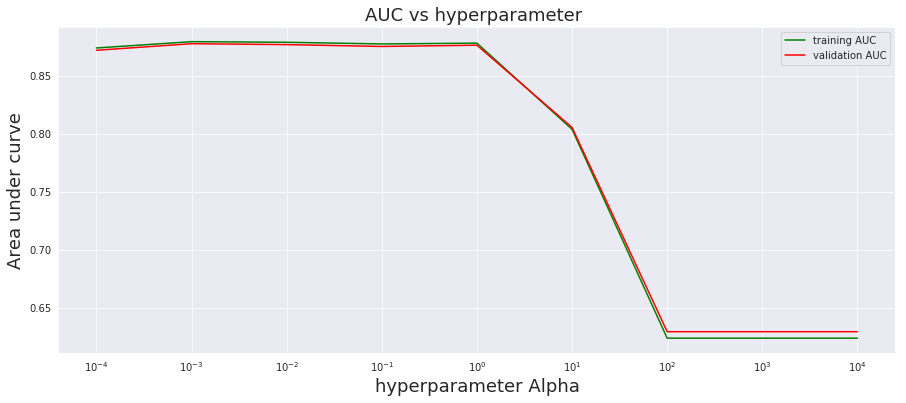

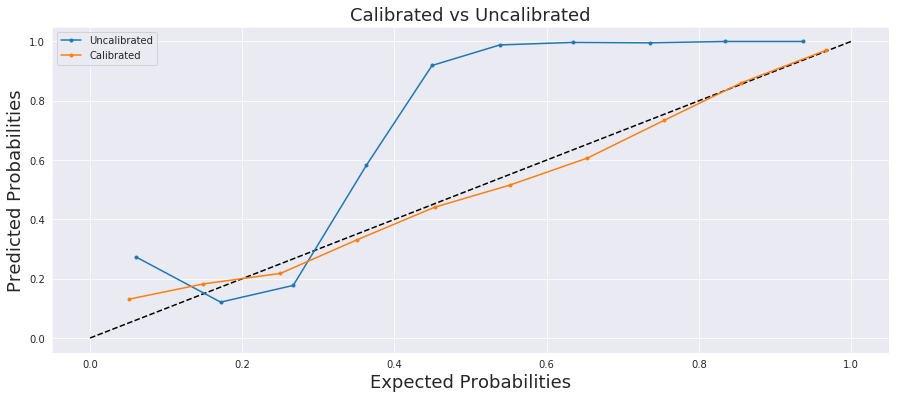

*********************************************************************

for Training data:

Confusion Matrix


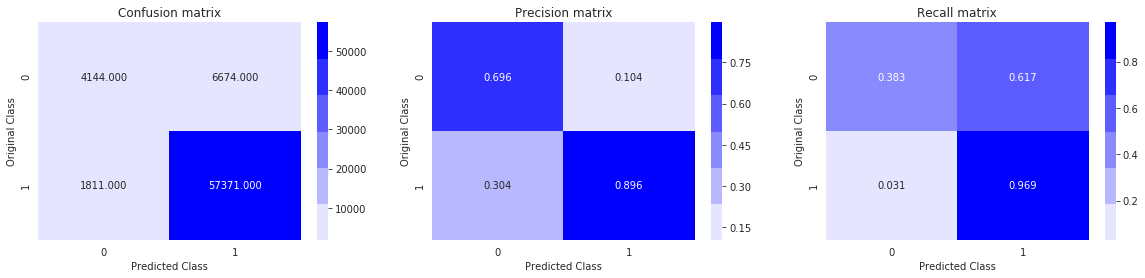

for Test data
Confusion Matrix


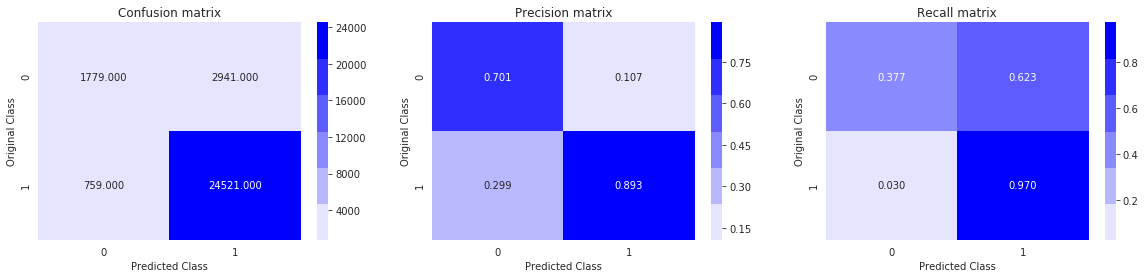

********************************************************

plotting ROC on Test data


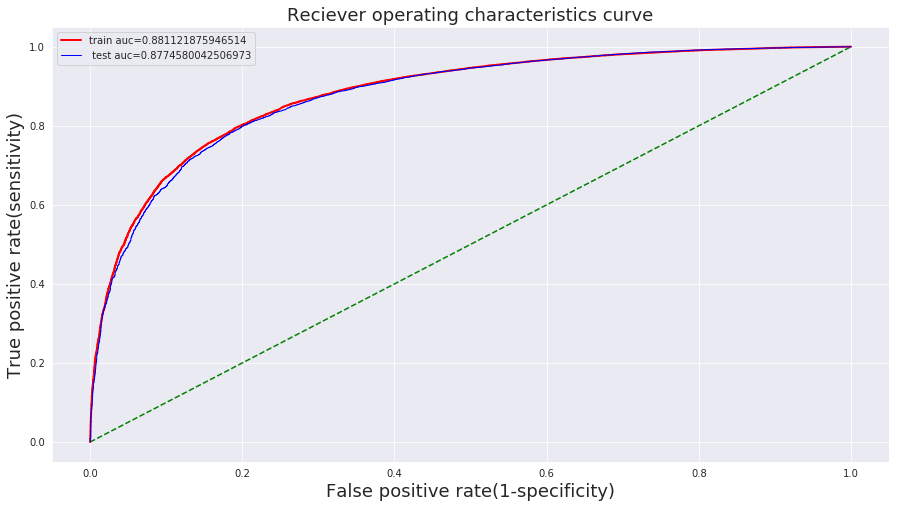

In [61]:
"""classifier for tuning"""
gsm = svm('l2',train_tfidfw2v,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l2_tfidfw2v = error('l2',train_tfidfw2v,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l2_tfidfw2v,test_auc_l2_tfidfw2v,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l2_tfidfw2v, 'l2',train_tfidfw2v,Y_train,test_tfidfw2v,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l2_tfidfw2v,'l2',train_tfidfw2v,test_tfidfw2v,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l2_tfidfw2v,test_auc_l2_tfidfw2v)


## Using L1 Regularization

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   16.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]},
             pre_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   15.9s finished


best hyperparameter is {'alpha': 0.001}
***************************************************************

AUC on training data is 0.8799045916367207
AUC on test data is 0.8762896407691483
*******************************************************************
The Calibration Curve


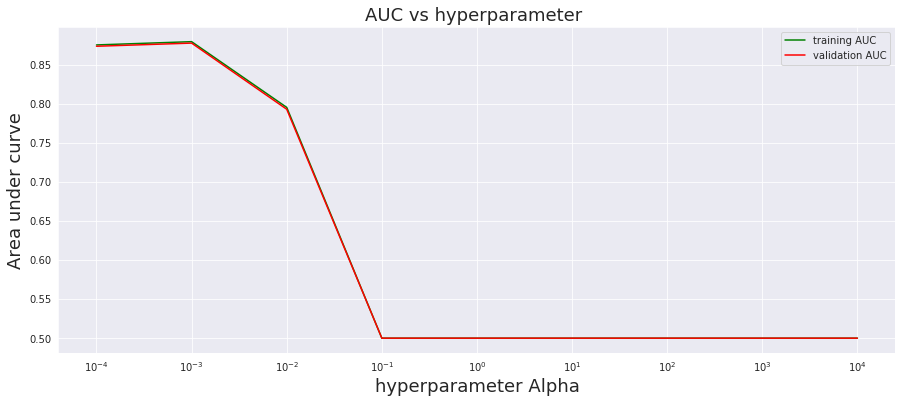

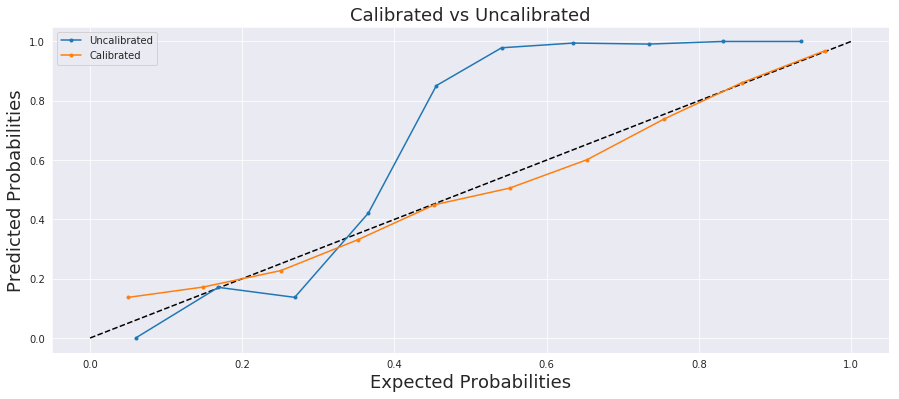

*********************************************************************

for Training data:

Confusion Matrix


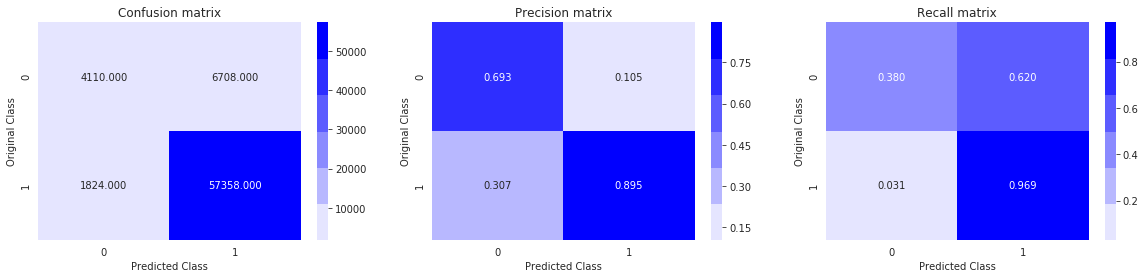

for Test data
Confusion Matrix


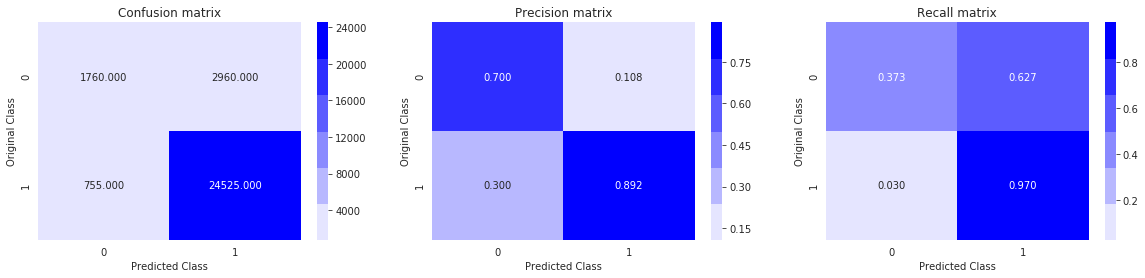

********************************************************

plotting ROC on Test data


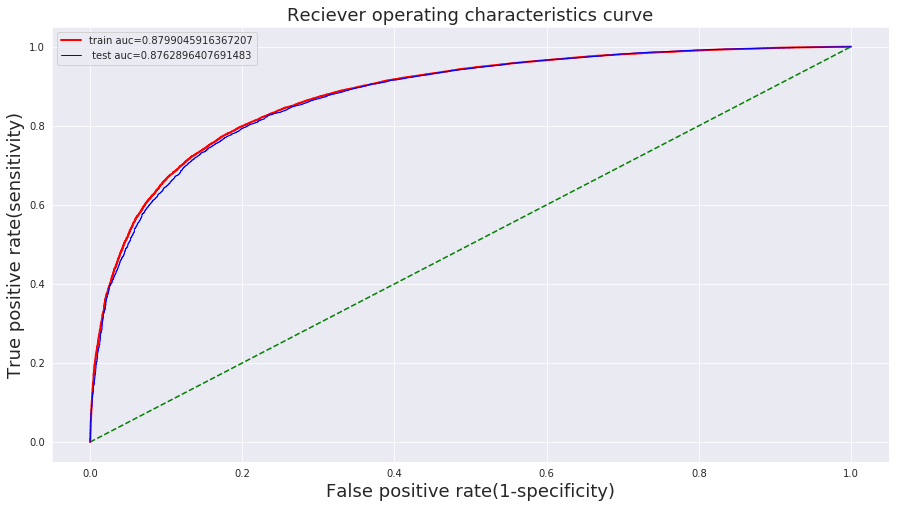

In [62]:
"""classifier for tuning"""
gsm = svm('l1',train_tfidfw2v,Y_train)
print(gsm)
print('***************************************************************\n')


"""best hyperparameter"""
best_alpha_l1_tfidfw2v = error('l1',train_tfidfw2v,Y_train)['alpha']
print('***************************************************************\n')


"""best Classifier fitted with tuned Hyperparameter"""
train_auc_l1_tfidfw2v,test_auc_l1_tfidfw2v,train_proba,test_proba,train_pred,test_pred = best_classifier(best_alpha_l1_tfidfw2v, \
                                            'l1',train_tfidfw2v,Y_train,test_tfidfw2v,Y_test)
print('*******************************************************************')


"""Reliability Curve"""
print('The Calibration Curve')
reliability_curve(best_alpha_l1_tfidfw2v,'l1',train_tfidfw2v,test_tfidfw2v,Y_train,Y_test)
print('*********************************************************************\n')

"""Confusion Matrix"""
print('for Training data:\n')
plot_confusion_matrix(Y_train,train_pred)

print('for Test data')
plot_confusion_matrix(Y_test,test_pred)
print('********************************************************\n')

"""ROC CURVE"""
plot_roc(Y_train,train_proba,Y_test,test_proba,train_auc_l1_tfidfw2v,test_auc_l1_tfidfw2v)


In [0]:
pickle.dump(best_alpha_l2_tfidfw2v,open('best_alpha_l2_tfidfw2v.p','wb'))
pickle.dump(test_auc_l2_tfidfw2v,open('test_auc_l2_tfidfw2v.p','wb'))
pickle.dump(best_alpha_l1_tfidfw2v,open('best_alpha_l1_tfidfw2v.p','wb'))
pickle.dump(test_auc_l1_tfidfw2v,open('test_auc_tfidfw2v.p','wb'))

# [6] Conclusions

In [63]:
from prettytable import PrettyTable 

#table for random forest
table = PrettyTable()
no = [1,2,3,4,5,6,7,8]
vectorizers = ['Bag of vectors','Bag of Vectors','TFIDF','TFIDF','Average Word 2 vector','Average Word 2 Vector','TFIDF Word 2 Vector','TFIDF Word 2 Vector']#all vectorizers
regularization = ['l2','l1','l2','l1','l2','l1','l2','l1']
alphas = [best_alpha_l2_bow,best_alpha_l1_bow,best_alpha_l2_tfidf,best_alpha_l1_tfidf,best_alpha_l2_avgw2v,best_alpha_l1_avgw2v,\
         best_alpha_l2_tfidfw2v,'0.001']
AUC = [test_auc_l2_bow,test_auc_l1_bow,test_auc_l2_tfidf,test_auc_l1_tfidf,test_auc_l2_avgw2v,test_auc_l1_avgw2v,\
       test_auc_l2_tfidfw2v,test_auc_l1_tfidfw2v]#their respective auc scores

table.add_column("SNo",no)
table.add_column('Vectorizers',vectorizers)
table.add_column('Regularization',regularization)
table.add_column('Hyperparameter(alpha)',alphas)
table.add_column('AUC on test',AUC)
print('\t\t\t Table for SGDClassifier using Hinge Loss')
print(table)

			 Table for SGDClassifier using Hinge Loss
+-----+-----------------------+----------------+-----------------------+--------------------+
| SNo |      Vectorizers      | Regularization | Hyperparameter(alpha) |    AUC on test     |
+-----+-----------------------+----------------+-----------------------+--------------------+
|  1  |     Bag of vectors    |       l2       |         0.001         | 0.9402083193654796 |
|  2  |     Bag of Vectors    |       l1       |         0.0001        | 0.9303229130350246 |
|  3  |         TFIDF         |       l2       |         0.0001        | 0.9557599378486376 |
|  4  |         TFIDF         |       l1       |         0.0001        | 0.9330814202960738 |
|  5  | Average Word 2 vector |       l2       |         0.001         | 0.9058933923111994 |
|  6  | Average Word 2 Vector |       l1       |         0.001         | 0.9056091185502038 |
|  7  |  TFIDF Word 2 Vector  |       l2       |         0.001         | 0.8774580042506973 |
|  8  |  TFIDF 

- We observed that the L2 regularization seems to work better than l1 regularization in almost all the cases.
- The L1 regularization becuase of creating sparsity,increase the value of coefficients of most important features.
- Caliberated Classifier tells more realistic picture of expected and predicted probabbilities,hence working greatly in this case of linear SVM.We plotted the reliability curve to actually see how closely the SGDClassifier fits the sigmoid function,thus using 'sigmoid'method rather than isotonic.
- Though Word 2 Vector gives semantic understanding ,then also simple TFIDF Scores gave best AUC Score